In [70]:
# this cell will make a zip file of all day that you can download from Files
i = 1
lst = ['/content/Day_ALL_1']
while i<=10:
    temp = f'Results_{i}.csv'
    lst.append(f'/content/{temp}')
    i += 1

!zip -r {' '.join(lst)}

  adding: content/Results_1.csv (deflated 97%)
  adding: content/Results_2.csv (deflated 97%)
  adding: content/Results_3.csv (deflated 98%)
  adding: content/Results_4.csv (deflated 97%)
  adding: content/Results_5.csv (deflated 97%)
  adding: content/Results_6.csv (deflated 97%)
  adding: content/Results_7.csv (deflated 98%)
  adding: content/Results_8.csv (deflated 98%)
  adding: content/Results_9.csv (deflated 98%)
  adding: content/Results_10.csv (deflated 98%)


<h1>AMLBio 2021</h1>
<h3>Prediction Notebook</h3>

In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math
import random
from scipy.stats import spearmanr, pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/AMLBio/AMLBio_2021/master/utils.py

from utils import *

--2021-02-04 22:52:50--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/Functions_Final_v3_1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22100 (22K) [text/plain]
Saving to: ‘Functions_Final_v3_1.py’

Functions_Final_v3_ 100%[===================>]  21.58K  --.-KB/s    in 0s      

2021-02-04 22:52:51 (54.9 MB/s) - ‘Functions_Final_v3_1.py’ saved [22100/22100]



# Help for each imported function is available:

In [2]:
help(random_combination_generator)

Help on function random_combination_generator in module Functions_Final_v3_1:

random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000, max_nl=None, drop_size_nl=100, check_repeat=True, rounded=2, verbose=0, make_csv=False, return_df=False)
    this function make random combination that is safe (e.g. dont make too much or low concentrated, not excecutable based on drop size, not repetitive)
    
    Parameters
    ----------
    concentrations_limits : dict
        {'name of metabolite': {'Conc_Min': #, 'Conc_Max': #, 'Conc_Values': #, 'Conc_Stock': #, 'Alternatives': #}, ...}
        
    Returns
    -------
    data : pandas.DataFrame
        a dataframe as consist of number_of_combination of random combinations



This notebook includes all data processing, bayesian optimization and results visualisation

# User Inputs

<p1><h2> When to use this part:</h2>
* every time before using this tool you should fill this part based on your project</p1>
<p1><h2> How to use this part:</h2>
* User should upload all available Results file (i.e. Results_1.csv to Results_n.csv) to runtime from Files/UploadFile
* now there is an example, change it to your project settings</p1>

In [6]:
# General Parameters:
#User Input
number_tested_each_day = 70
m = 70      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 20000 # (e.g. volume except fixed parts - 100 nl avoid 0 water)
fixed_parts = {} 
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 

"""
exploration = {1: 1.41, 2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0,
               8: 0.5, 9: 0.5, 9: 0.5, 10: 0.5}"""

days_range = [m for i in range(days_total)]

In [7]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'I48':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'Y134':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'E135':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'A415':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'M442':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'Y497':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'E567':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'S568':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 'I571':{'Conc_Min':0.0, 'Conc_Max':0.0, 'Conc_Values':None, 'Conc_Stock':1.0, 'Alternatives':['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']},
 }

In [8]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {}

# Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
all_data = pd.read_csv('Mutants.csv')
all_data_y = all_data[['yield']]
all_data_x = all_data.drop(columns='yield')
all_data_x

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
seed = 41
X_train, X_test, y_train, y_test = train_test_split(all_data_x, all_data_y, test_size = 0.15, random_state = seed)

# Random Day 1

In [ ]:
index_dic = {}
index_set = set(range(len(X)))
# chose random subset for day_1
index_dic[1] = np.random.choice(list(index_set), size=number_tested_each_day, replace=False)
# remove day_1 indexs from index_set
index_set -= set(index_dic[1])

In [ ]:
Results_1 = pd.concat([X.iloc[index_dic[1],:], y.iloc[index_dic[1],:]], axis=1)
Results_1

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD,yield
775,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.400000,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,3.2,25.0,1.5,0.0100,0.000000
963,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.400000,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.404242
306,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.000000,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,0.0,2.5,15.2,10.0,2.5,0.0075,0.758416
441,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.000000,100.0,3.0,0.3,0.3,0.3,0.3,0.3,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.902289
202,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,121.561,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.000000,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.036884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.400000,1.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.506533
22,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,0.759890,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.992440
19,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,7.598897,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.964315
448,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.000000,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.921763


In [ ]:
Results_1.to_csv('Results_1.csv', index=False)

# Random Other Days

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

1 1


In [ ]:
# chose random subset for day_1
index_dic[day+1] = np.random.choice(list(index_set), size=number_tested_each_day, replace=False)
# remove day_1 indexs from index_set
index_set -= set(index_dic[day+1])

In [ ]:
Results_n = pd.concat([X.iloc[index_dic[day+1],:], y.iloc[index_dic[day+1],:]], axis=1)
Results_n

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD,yield
428,24600.0,1000.0,1200.0,1000.000000,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,250.000000,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.986882
943,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.1,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.376769
1011,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,8.6,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.294351
1046,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,170.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.374528
744,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,0.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,0.008491
348,24600.0,1000.0,1200.0,1000.000000,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,250.000000,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.5,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.372598
698,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,3650.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.302864
1009,12300.0,600.0,730.0,650.000000,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,8.0,10.0,0.2,85.0,4.30,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,750.000000,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.360693
191,24600.0,1000.0,1200.0,1000.000000,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.30,37.000,40.0,9.872242,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,250.000000,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.954779
213,24600.0,1000.0,1200.0,1000.000000,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,0.43,37.000,40.0,60.000000,550.0,27.0,33.0,39.0,85.0,28.0,152.000000,114.0,5.9,1400.0,250.000000,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,

In [ ]:
Results_n.to_csv(f'Results_{day+1}.csv', index=False)

# Other Days version_1


In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

1 0


In [ ]:
def bayesian_optimization(regressors_list,
                          data, label,
                          concentrations_limits,
                          final_order,
                          df_main=None,
                          df_to_rank=None,
                          repeat_check=True,
                          df_rank=False,
                          reaction_vol_nl=20000, max_nl=13200, drop_size_nl=100,
                          exploitation=1, exploration=1, test_size=100, pool_size=100000, verbose=0, day=1,
                          days_range=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]):
    """Main bayesian optimization function
        
    Parameters
    ----------
    regressors_list : 
        a list consists of more than one regressor that has .fit and .predict feature
    
    data : pandas.DataFrame
        all previous day data

    label : pandas.DataFrame
        all previous day label
        
    exploitation : 1
        coeficient of focus on higher yield query
    
    exploration : 1
        coefficient of focus on more informative query
        
    test_size : 100
        output combinations number
        
    pool_size : 100000
        how many random combinations to ask from regressor list each round
        caution: this parameter highly affect executions time
        
    Returns
    -------
    chosen_combinations: pandas.DataFrame
        combinations that expected to improve yield
    """
    # first fit training data on our models
    for regressor in regressors_list:
        regressor.fit(data.values, label.values)

    if df_rank:
        df_1 = df_to_rank.copy(deep=True)
    else:
        # make random test data
        df_1 = random_combination_generator(concentrations_limits, number_of_combination=pool_size,
                                            reaction_vol_nl=reaction_vol_nl,
                                            max_nl=max_nl, drop_size_nl=drop_size_nl, make_csv=False, return_df=True)
    desired_cols = list(df_1.columns)

    df_temp = df_1.copy(deep=True)

    # Upper Confidence Bound
    for index, regressor in enumerate(regressors_list):
        df_1['pred_yield_{}'.format(index)] = regressor.predict(df_temp.values)

    df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
    df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
    df_1['UCB'] = exploitation * df_1['mean_vote'] + exploration * df_1['regressors_std']
    df_1 = df_1.sort_values(['UCB'], ascending=False)

    """
    # check to don`t make repeated combination but it is not likely
    chosen_combinations = pd.DataFrame(columns=desired_cols)
    num = 0
    count = 0
    for i in df_1[desired_cols].values:
        count += 1
        temp_combination = pd.DataFrame([i], columns=desired_cols)
        print(num, count, check_repetitive(temp_combination, df_main), i)
        if check_repetitive(temp_combination, df_main) or not repeat_check:
            num += 1
            chosen_combinations = pd.concat([chosen_combinations, temp_combination]).reset_index(drop=True)
        if num == test_size:
            break
    return chosen_combinations[final_order]"""
    if repeat_check:
        total_df = pd.concat([df_1[desired_cols], df_main])
        cleared_df = total_df.drop(index = total_df[total_df.duplicated(keep=False)].index)
        return cleared_df.iloc[:test_size, :]
    else:
        return df_1[desired_cols].iloc[:test_size, :]

In [ ]:
desired_cols = ['IF1', 'IF2', 'IF3', 'EF-G', 'EF-Tu', 'EF-Ts', 'RF1', 'RF2', 'RF3',
       'RRF', 'AlaRS', 'ArgRS', 'AsnRS', 'AspRS', 'CysRS', 'GlnRS', 'GluRS',
       'GlyRS', 'HisRS', 'IleRS', 'LeuRS', 'LysRS', 'MetRS', 'PheRS', 'ProRS',
       'SerRS', 'ThrRS', 'TrpRS', 'TyrRS', 'ValRS', 'MTF', 'MK', 'CK', 'NDK',
       'PPiase', 'T7 pol', 'Ribosome', 'Ala', 'Arg', 'Asn', 'Asp', 'Cys',
       'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro',
       'Ser', 'Thr', 'Tyr', 'Trp', 'Val', 'ATP', 'GTP', 'CTP', 'UTP', 'tRNA',
       'HEPES', 'K-Glu', 'spermidine', 'Mg(OAc)2', 'CP', 'DTT', 'FD']

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

aggregated_data_m

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD
0,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,3.2,25.0,1.5,0.0100
1,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
2,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,0.0,2.5,15.2,10.0,2.5,0.0075
3,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
4,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,121.561,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
316,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
317,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.5,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
318,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.000,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100


In [ ]:
aggregated_data_m[aggregated_data_m.duplicated()]

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD


In [ ]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons

    param_grid = {
            "learning_rate": [0.1, 0.5, 1.0, 1.5],
            "colsample_bytree": [0.9, 0.95, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [50, 100, 200, 300],
            "reg_lambda": [1.0, 1.2],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=200)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
t0 = time.time()

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           df_to_rank = X,
                                           repeat_check=True,
                                           df_rank=True,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation = 0, exploration = 1, test_size=m, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  2.86775541305542


,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD
754,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,12.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
756,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,3.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
753,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,18.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
874,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
744,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,0.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
391,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
407,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
440,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075


In [ ]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [ ]:
# check to dont make repeated combination
df_main = aggregated_data_m

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

['left_only', 'both', 'right_only']
Categories (3, object): ['left_only', 'both', 'right_only']

In [ ]:
t = pd.concat([pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)), aggregated_data_m])
t[t.duplicated(keep=False)]

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD
20,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,1.998723,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075
240,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.0,40.0,1.998723,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075


In [ ]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

Find Labels and Generate Results

In [ ]:
this_day = Concentrations_n.copy(deep=True)
col_names = this_day.columns
this_day['yield'] = 'NA'
aggregated = pd.concat([all_data, Concentrations_n])
aggregated

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD,yield
0,2470.0,410.0,730.0,1290.0,2320.0,3300.0,250.0,490.0,170.0,490.0,730.0,31.000000,420.0,120.0,24.0,60.0,230.0,85.0,85.0,370.0,40.0,115.0,110.0,135.0,170.0,39.0,85.0,28.0,7.5,17.0,590.0,140.0,95.0,70.0,41.0,100.0,1.20,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,2.1,50.0,50.0,2.0,14.6,20.0,1.0,0.0100,1.374528
1,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,4.43,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.073615
2,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,4.00,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.131127
3,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.50,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.270791
4,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,2.50,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.150927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.00,1.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,NaN
76,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.00,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,10.0,140.0,2.5,15.2,10.0,2.5,0.0075,NaN
77,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.00,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,NaN
78,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.000000,21.0,40.0,12.0,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.00,0.3,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,NaN


In [ ]:
Results_n = aggregated[aggregated.duplicated(subset=aggregated.columns[:-1], keep='last')]
Results_n

,IF1,IF2,IF3,EF-G,EF-Tu,EF-Ts,RF1,RF2,RF3,RRF,AlaRS,ArgRS,AsnRS,AspRS,CysRS,GlnRS,GluRS,GlyRS,HisRS,IleRS,LeuRS,LysRS,MetRS,PheRS,ProRS,SerRS,ThrRS,TrpRS,TyrRS,ValRS,MTF,MK,CK,NDK,PPiase,T7 pol,Ribosome,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Tyr,Trp,Val,ATP,GTP,CTP,UTP,tRNA,HEPES,K-Glu,spermidine,Mg(OAc)2,CP,DTT,FD,yield
240,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,1.998723,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.103494
241,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,1.199234,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.144395
244,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,134.547294,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,2.080537
251,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,69.974555,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.959642
253,24600.0,1000.0,1200.0,1000.0,80000.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,6.997455,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,250.0,16.0,41.0,100.0,3.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,1.0,0.0,0.0,1.6,100.0,140.0,2.5,15.2,10.0,2.5,0.0075,1.942356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.363169
904,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.309859
905,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.5,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.372168
906,12300.0,600.0,730.0,650.0,15250.0,3300.0,50.0,50.0,170.0,3900.0,73.0,3.0,21.000000,40.000000,12.000000,10.0,0.2,85.0,4.3,37.0,40.0,60.0,550.0,27.0,33.0,39.0,85.0,28.0,152.0,114.0,5.9,1400.0,750.0,95.0,1.4,0.0,2.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.3,2.0,2.0,1.0,1.0,3.1,40.0,100.0,1.5,12.2,25.0,1.5,0.0100,1.373718


In [ ]:
Results_n.to_csv(f'Results_{day+1}.csv', index=False)

# Day 1 Activelearning

In [11]:
Temp_df = pd.concat([X_train, y_train], axis=1)

In [12]:
index_dic = {}
index_set = set(range(len(Temp_df)))
# chose random subset for day_1
index_dic[1] = np.random.choice(list(index_set), size=number_tested_each_day, replace=False)
# remove day_1 indexs from index_set
index_set -= set(index_dic[1])

In [13]:
Results_1 = Temp_df.iloc[index_dic[1],:]
Results_1

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y,yield
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323555
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.627926
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.482535
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.964988


In [14]:
Results_1.to_csv('Results_1.csv', index=False)

In [15]:
Temp_df = Temp_df.iloc[list(index_set), :]
Temp_df

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y,yield
694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,319.924312
315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.052290
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.534564
321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.052290


# Other Days version_2


In [64]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]
print(start_day, day)

1 9


In [65]:
desired_cols = list(X_train.columns)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

aggregated_data_m

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons

    param_grid = {
            "learning_rate": [0.1, 0.5, 1.0, 1.5],
            "colsample_bytree": [0.9, 0.95, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [50, 100, 200, 300],
            "reg_lambda": [1.0, 1.2],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=200)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...
RandomSearchCV Done!


In [67]:
def bayesian_optimization(regressors_list,
                          data, label,
                          concentrations_limits,
                          final_order,
                          df_main=None,
                          df_to_rank=None,
                          repeat_check=True,
                          df_rank=False,
                          reaction_vol_nl=20000, max_nl=13200, drop_size_nl=100,
                          exploitation=1, exploration=1, test_size=100, pool_size=100000, verbose=0, day=1,
                          days_range=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]):
    """Main bayesian optimization function
        
    Parameters
    ----------
    regressors_list : 
        a list consists of more than one regressor that has .fit and .predict feature
    
    data : pandas.DataFrame
        all previous day data

    label : pandas.DataFrame
        all previous day label
        
    exploitation : 1
        coeficient of focus on higher yield query
    
    exploration : 1
        coefficient of focus on more informative query
        
    test_size : 100
        output combinations number
        
    pool_size : 100000
        how many random combinations to ask from regressor list each round
        caution: this parameter highly affect executions time
        
    Returns
    -------
    chosen_combinations: pandas.DataFrame
        combinations that expected to improve yield
    """
    # first fit training data on our models
    for regressor in regressors_list:
        regressor.fit(data.values, label.values)

    if df_rank:
        df_1 = df_to_rank.copy(deep=True)
    else:
        # make random test data
        df_1 = random_combination_generator(concentrations_limits, number_of_combination=pool_size,
                                            reaction_vol_nl=reaction_vol_nl,
                                            max_nl=max_nl, drop_size_nl=drop_size_nl, make_csv=False, return_df=True)
    desired_cols = final_order

    df_temp = df_1.copy(deep=True)

    # Upper Confidence Bound
    for index, regressor in enumerate(regressors_list):
        df_1['pred_yield_{}'.format(index)] = regressor.predict(df_temp[desired_cols].values)

    df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
    df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
    df_1['UCB'] = exploitation * df_1['mean_vote'] + exploration * df_1['regressors_std']
    df_1 = df_1.sort_values(['UCB'], ascending=False)

    df_results = df_1[desired_cols + ['yield']].iloc[:test_size, :]
    df_remained = df_1[desired_cols + ['yield']].iloc[test_size:, :]

    return df_results, df_remained

In [68]:
Results_n, Temp_df = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           df_main = aggregated_data_m,
                                           df_to_rank = Temp_df,
                                           repeat_check=True,
                                           df_rank=True,
    
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation = 0, exploration = 1, test_size=m, verbose=0,
                                           day=day, days_range = days_range)

In [69]:
Results_n.to_csv(f'Results_{day+1}.csv', index=False)

# Calculate R2 of Results

In [71]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [72]:
r2_df = pd.DataFrame(columns=['Type', 'Replicate', 'Day', 'R2-Spearman', 'R2-Pearson', 'MAE', 'MSE'])

Type = 'Active'
start_day = 1

desired_cols = list(X_train.columns)


final_order = desired_cols

index = 0
for replicate in ['A4']:
#for replicate in ['A1', 'A2', 'A3', 'A4', 'A5']:

    print(replicate)
    for day in range(1, 11):
        print(day)

        # Preprocess Data
        aggregated_data_m = pd.DataFrame(columns=desired_cols)
        aggregated_label_m = pd.DataFrame(columns=['yield'])

        for num in range(start_day, day + 1):
            temp = pd.read_csv(f'Results_{num}.csv')
            data_m = temp[desired_cols]
            label_m = temp[['yield']]

            aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
            aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

        
        # Find Best Parameter
        # Create the grid search parameter grid and scoring funcitons
        param_grid = {
            "learning_rate": [0.1, 0.5, 1.0, 1.5],
            "colsample_bytree": [0.9, 0.95, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [50, 100, 200, 300],
            "reg_lambda": [1.0, 1.2],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

        # create the grid search object
        model = XGBRegressor(objective = 'reg:squarederror')
        grid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid,
            cv=5,
            scoring= 'neg_mean_absolute_error',
            n_jobs=-1,
            n_iter = 48)

        print(len(aggregated_data_m))
        print('RandomSearchCV...')
        grid.fit(aggregated_data_m.values, aggregated_label_m.values)
        results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
        print('RandomSearchCV Done!')
        
        # Train The Model
        best_param = results.params.iloc[0,]
        model = XGBRegressor(objective = 'reg:squarederror', **best_param)
        """
        model = XGBRegressor(objective = 'reg:squarederror', learning_rate=1.0, n_estimators=300,
                          booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                          max_delta_step=0, subsample=1.0, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                          reg_lambda=1, scale_pos_weight=1, base_score=0.5)"""
        model.fit(aggregated_data_m.values, aggregated_label_m.values)
        spearman_r2 = spearmanr(model.predict(X_test.values), y_test.values).correlation**2
        pearson_r2 = r2_score(model.predict(X_test.values), y_test.values)
        mae = mean_absolute_error(model.predict(X_test.values), y_test.values)
        mse = mean_squared_error(model.predict(X_test.values), y_test.values)

        r2_df.loc[index] = [Type, replicate, day, spearman_r2, pearson_r2, mae, mse]
        index += 1

r2_df

A4
1
70
RandomSearchCV...
RandomSearchCV Done!
2
140
RandomSearchCV...
RandomSearchCV Done!
3
210
RandomSearchCV...
RandomSearchCV Done!
4
280
RandomSearchCV...
RandomSearchCV Done!
5
350
RandomSearchCV...
RandomSearchCV Done!
6
420
RandomSearchCV...
RandomSearchCV Done!
7
490
RandomSearchCV...
RandomSearchCV Done!
8
560
RandomSearchCV...
RandomSearchCV Done!
9
630
RandomSearchCV...
RandomSearchCV Done!
10
700
RandomSearchCV...
RandomSearchCV Done!


,Type,Replicate,Day,R2-Spearman,R2-Pearson,MAE,MSE
0,Active,A4,1,0.075132,-0.007808,65.546402,23321.735313
1,Active,A4,2,0.311405,0.176123,37.791361,14604.978616
2,Active,A4,3,0.408373,0.778777,12.683467,1493.888122
3,Active,A4,4,0.585061,0.633623,16.664010,1962.429243
4,Active,A4,5,0.612408,0.673187,13.249142,1721.959426
5,Active,A4,6,0.635962,0.670043,9.046355,2335.582933
6,Active,A4,7,0.593552,0.707550,12.691716,1632.468244
7,Active,A4,8,0.616265,0.681840,11.592139,1708.355706
8,Active,A4,9,0.596172,0.678755,12.411537,1733.167670
9,Active,A4,10,0.445675,0.673084,12.343929,1663.950034


In [73]:
aggregated_data_m[aggregated_data_m.duplicated()]

,I48,I48_A,I48_C,I48_D,I48_E,I48_F,I48_G,I48_H,I48_I,I48_K,I48_L,I48_M,I48_N,I48_P,I48_Q,I48_R,I48_S,I48_T,I48_V,I48_W,I48_Y,Y134,Y134_A,Y134_C,Y134_D,Y134_E,Y134_F,Y134_G,Y134_H,Y134_I,Y134_K,Y134_L,Y134_M,Y134_N,Y134_P,Y134_Q,Y134_R,Y134_S,Y134_T,Y134_V,...,S568_C,S568_D,S568_E,S568_F,S568_G,S568_H,S568_I,S568_K,S568_L,S568_M,S568_N,S568_P,S568_Q,S568_R,S568_S,S568_T,S568_V,S568_W,S568_Y,I571,I571_A,I571_C,I571_D,I571_E,I571_F,I571_G,I571_H,I571_I,I571_K,I571_L,I571_M,I571_N,I571_P,I571_Q,I571_R,I571_S,I571_T,I571_V,I571_W,I571_Y
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
r2_df.to_csv('active.csv', index=False)

In [ ]:
param_grid = {
            "learning_rate": [0.1, 0.3],
            "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [100, 300],
            "reg_lambda": [1.0],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

# create the grid search object
model = XGBRegressor(objective = 'reg:squarederror')
grid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid,
            cv=5,
            scoring= 'neg_mean_absolute_error',
            n_jobs=-1,
            n_iter = 48)

print('RandomSearchCV...')
grid.fit(X.values, y.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

In [ ]:
model_test = XGBRegressor(objective = 'reg:squarederror', learning_rate=1.0, n_estimators=300,
                          booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                          max_delta_step=0, subsample=1.0, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                          reg_lambda=1, scale_pos_weight=1, base_score=0.5)

ind = np.random.choice(range(len(X)), size=800, replace=False)
model_test.fit(X.iloc[ind], y.iloc[ind])
r2_score(model_test.predict(X_test), y_test)

# All Data R2 CV 5

In [12]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

param_grid = {
            "learning_rate": [0.1, 0.3],
            "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
            "subsample": [0.9, 1.0],
            "n_estimators": [100, 300],
            "reg_lambda": [1.0],
            "gamma": [0, 0.1],
            "min_child_weight": [1, 2]}

# create the grid search object
model = XGBRegressor(objective = 'reg:squarederror')
grid = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid,
            cv=5,
            scoring= 'neg_mean_absolute_error',
            n_jobs=-1,
            n_iter = 48)

print('RandomSearchCV...')
grid.fit(all_data_x.values, all_data_y.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')


RandomSearchCV...
RandomSearchCV Done!


In [13]:
# create model
model = XGBRegressor(**results['params'].iloc[0])
# evaluate model
scores = cross_val_score(model, all_data_x.values, all_data_y.values, scoring='r2', cv=cv, n_jobs=-1)
# report performance
print('R2: %.3f (%.3f)' % (mean(scores), std(scores)))

R2: 0.648 (0.140)


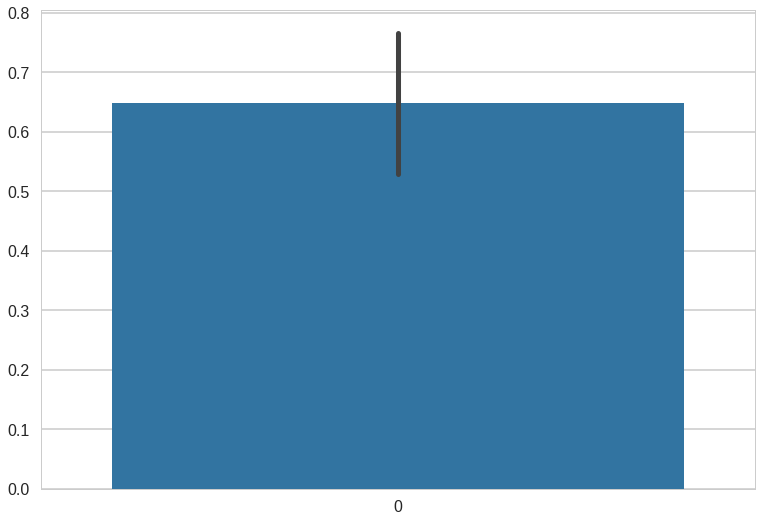

In [14]:
sns.barplot(data=scores)

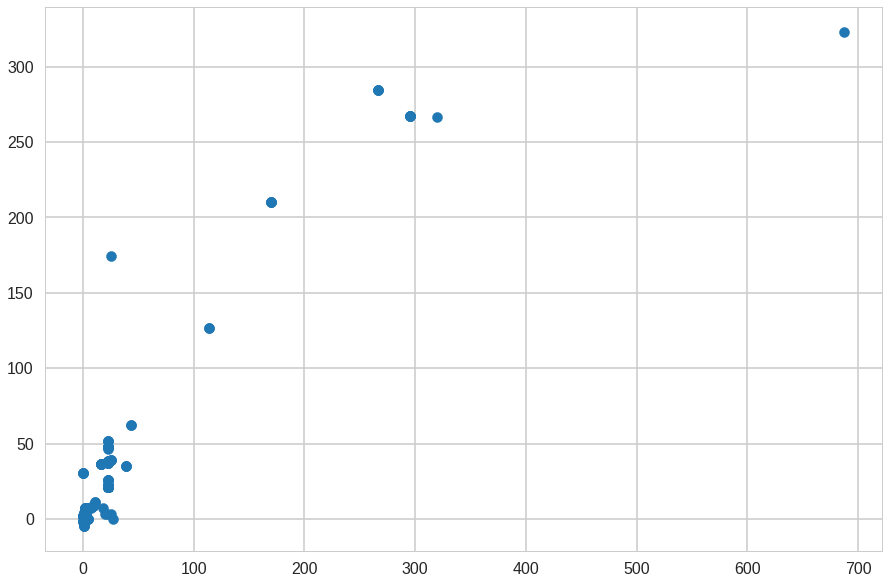

In [16]:
seed = 23
X_train, X_test, y_train, y_test = train_test_split(all_data_x, all_data_y, test_size = 0.2, random_state = seed)

model_plot = XGBRegressor(objective='reg:squarederror',**results['params'].iloc[0])
model_plot.fit(X_train, y_train)

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax = plt.scatter(y_test, model_plot.predict(X_test), s=100)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, model_plot.predict(X_test))

0.6507910209939685

# Visualising R2

In [2]:
pd.read_csv('active_1.csv')['R2-Pearson']

0   -0.007808
1    0.176123
2    0.778777
3    0.633623
4    0.673187
5    0.670043
6    0.707550
7    0.681840
8    0.678755
9    0.673084
Name: R2-Pearson, dtype: float64

In [3]:
result_df = pd.DataFrame(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5',
                                  'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10'],
                         data=np.zeros((5,10)))
for i in range(10):
    result_df[f'Day_{i+1}'] = [pd.read_csv(f'active_{j}.csv')['R2-Pearson'][i] for j in range(1, 6)]

result_df

,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10
0,-0.007808,0.176123,0.778777,0.633623,0.673187,0.670043,0.707550,0.681840,0.678755,0.673084
1,-0.572205,0.700587,0.650594,0.640109,0.715314,0.700938,0.689129,0.680440,0.731985,0.686942
2,0.072452,0.655075,0.497550,0.436316,0.684121,0.666282,0.650273,0.620170,0.629992,0.714177
3,0.464217,-0.756447,0.615253,0.653154,0.682593,0.668217,0.681463,0.707749,0.726461,0.687377
4,0.468983,0.673521,0.631565,0.452374,0.645333,0.683525,0.673945,0.682940,0.651072,0.681827


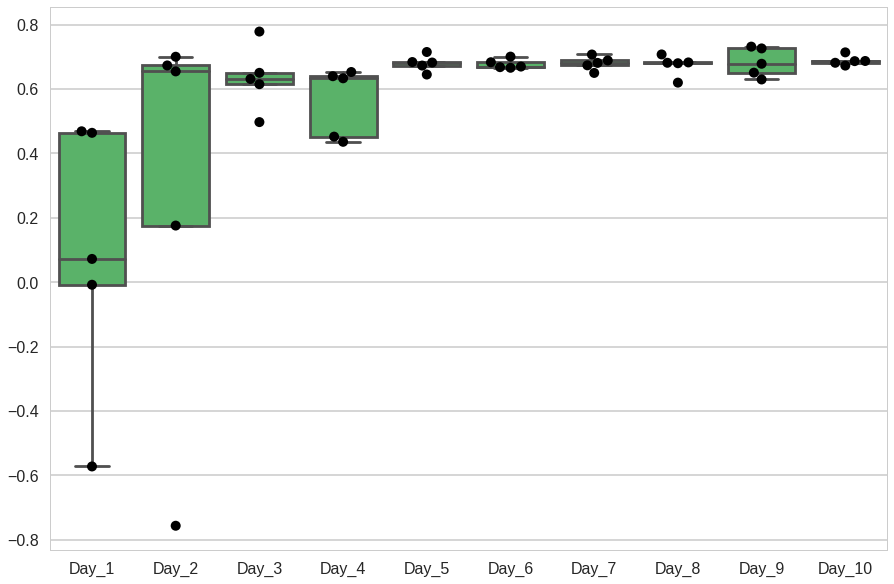

In [4]:
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax = sns.boxplot(data=result_df, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(data=result_df, color='k', size=10)

# Visualising Results as BoxPlot


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


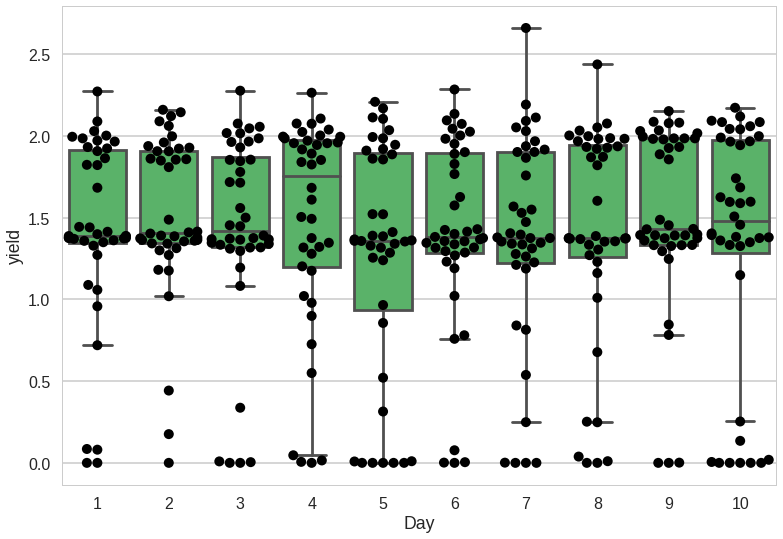

In [ ]:
display_std = True # if you have included "yield_std" column in Results.csv will show it else disply 0 for std

day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(start_day, day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    if start_day:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    else:
        Results_i['yield'] = pd.read_csv(f'Results_{i}.csv')['yield'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    try:
        if start_day:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
        else:
            Results_i['std'] = pd.read_csv(f'Results_{i}.csv')['yield_std'].iloc[0:len(pd.read_csv('Results_0.csv'))]

    except:
        Results_i['std'] = 0
    Results_i['Day'] = i
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, color='#4BC15F', fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    order = 0
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            std = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['std'][order]
            y_Result = Results_m.sort_values(['Day', 'yield'], ignore_index=True)['yield'][order]
            ax.arrow(x, y-(std/2), dx=0, dy=std, linewidth=1, zorder=4, width=0, color='grey')

            order += 1

    errors = Results_m['std']

#ax.set_ylim(top=60000)
ax

In [ ]:
fig.savefig(f'Day_{day-1}_Boxplot.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Boxplot.svg', format='svg', dpi=1200)

# Visualising Results For Each Metabolite

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

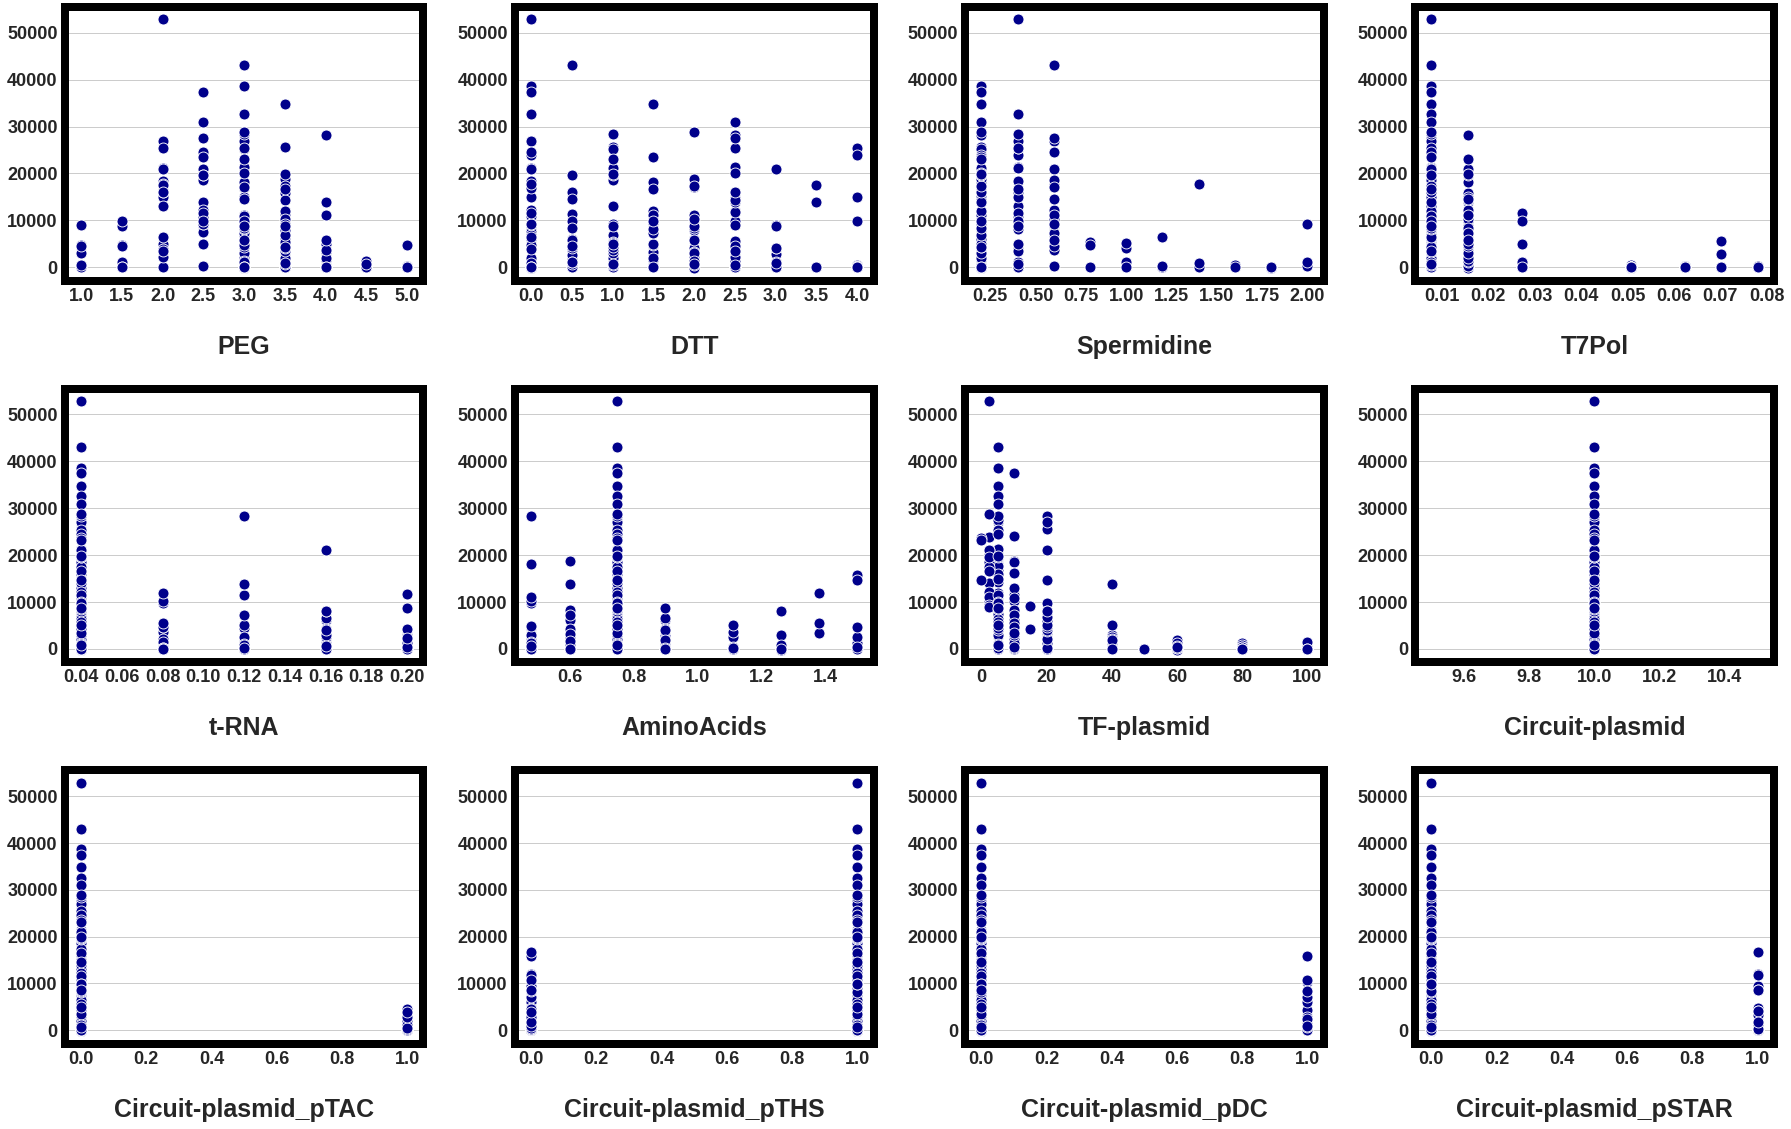

In [ ]:
desired_cols = []
day = day_finder('Results')
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day):
    if start_day:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

plt.style.use('seaborn-whitegrid')

num = len(desired_cols)
dim = math.ceil(math.sqrt(num))
data = pd.concat([aggregated_data_m, aggregated_label_m], axis=1)

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally

fig = plt.figure(figsize=(25,20))

for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax.xaxis.grid(False)
    ax = sns.scatterplot(x = desired_cols[i-1], y='yield', color='darkblue', data=data, s=120)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    y_label.set_visible(False)
    #ax.xaxis.set_tick_params()
    plt.xticks(weight = 'bold', fontsize=18)
    plt.yticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Yield.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Yield.svg', format='svg', dpi=1200)

# Viualising Concentrations From Day_1 to Now

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file 
<p1><h2> How to use this part:</h2>
* just run all cells!
* you can change some graphing parameter

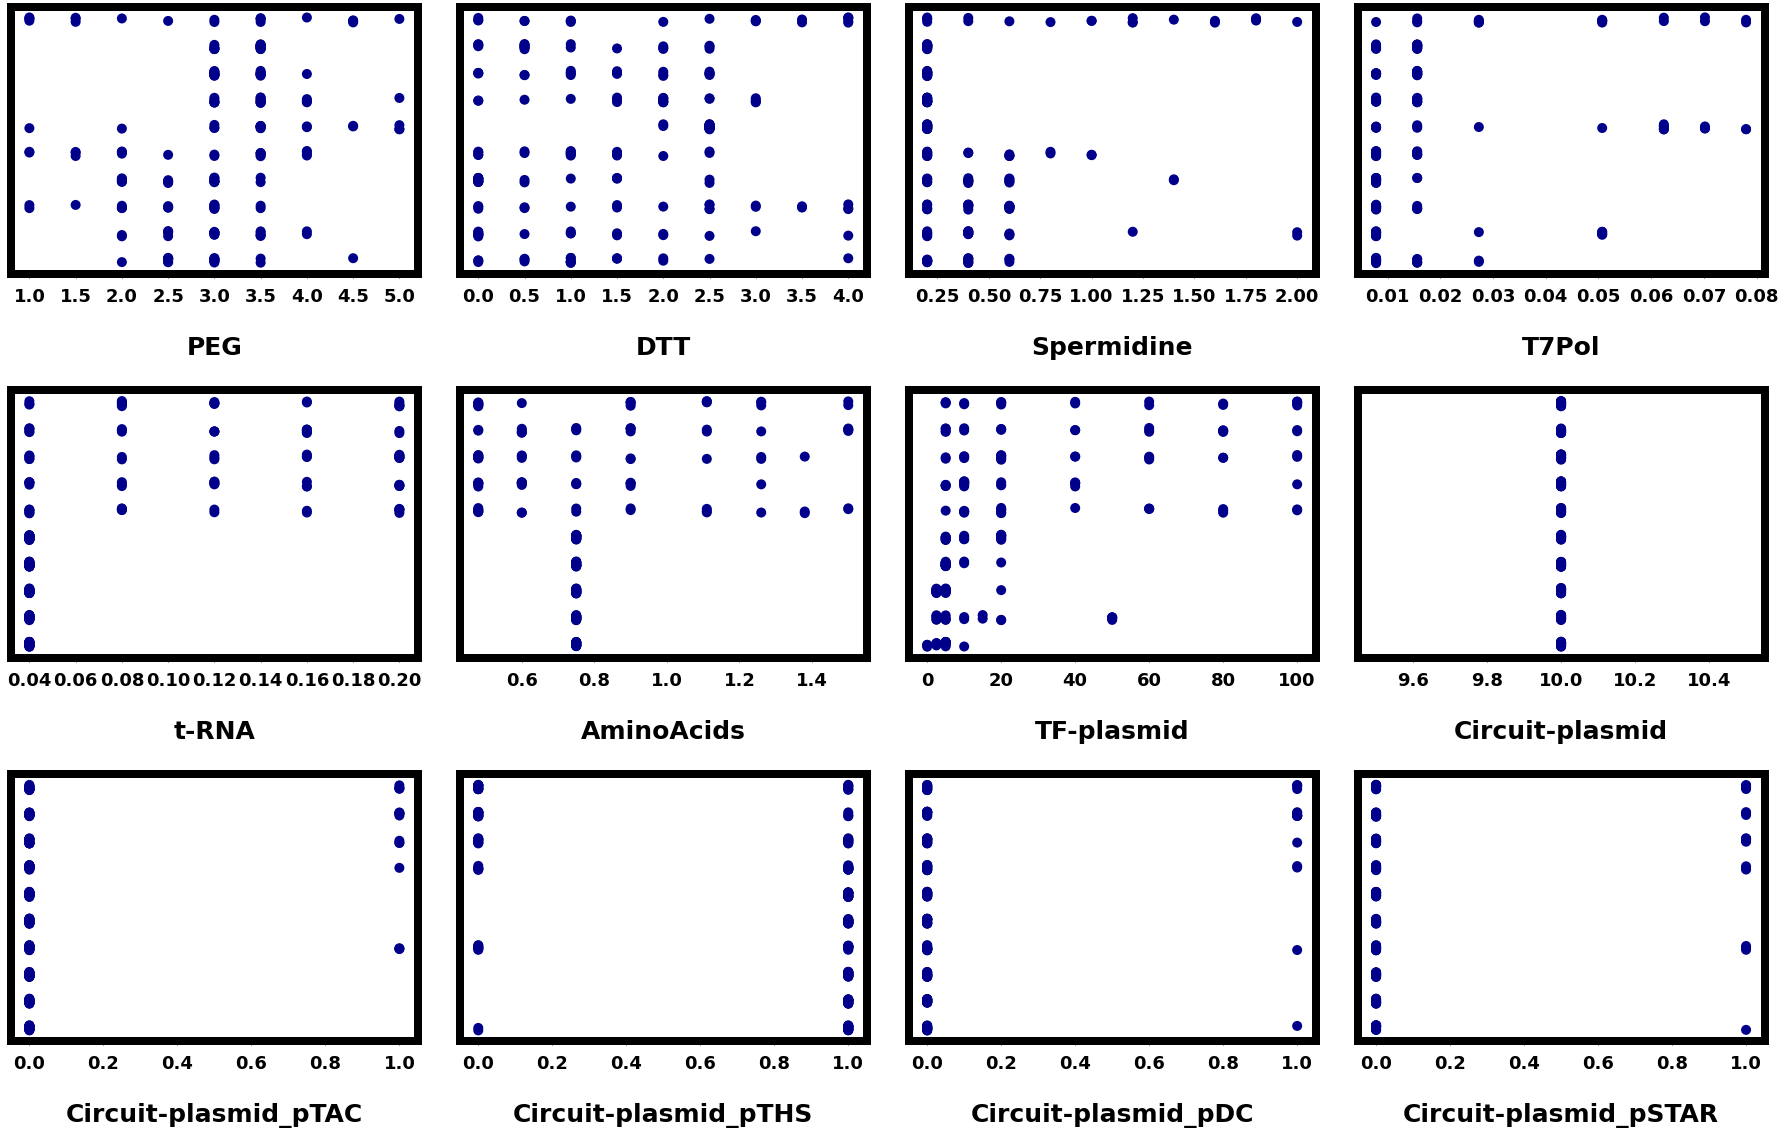

In [ ]:
data_all = pd.DataFrame(columns = list(concentrations_limits.keys())+['day'])
day = day_finder('Results')
desired_cols = []

# make column name:
desired_cols = []
for key, value in concentrations_limits.items():
    if not value['Alternatives']:
        desired_cols.append(key)
    else:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name

final_order = desired_cols

d = (1, 0)[os.path.isfile('Results_0.csv')]

while os.path.exists(f'Results_{d}.csv'):
    data = pd.read_csv(f'Results_{d}.csv')
    data = data[desired_cols]
    data = data.iloc[:days_range[d-1],:]
    data['day'] = f'Day_{d}'
    data_all = pd.concat([data_all, data]).reset_index(drop=True)
    d += 1

import matplotlib as mpl


mpl.rcParams['axes.linewidth'] = 8.0 #set the value globally
mpl.rcParams['axes.edgecolor'] = 'black' #set the value globally
mpl.rcParams['xtick.major.pad'] = 10.0 #set the value globally


num = len(desired_cols)
dim = math.ceil(math.sqrt(num))

fig = plt.figure(figsize=(25,20))
for i in range(1, num+1):
    ax = plt.subplot(dim, dim, i)
    ax = sns.stripplot(x=desired_cols[i-1], y="day", color='darkblue', data=data_all, s=10)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    ax.yaxis.set_ticklabels([])
    plt.xticks(weight = 'bold', fontsize=18)

    plt.xlabel(desired_cols[i-1], labelpad=30 ,fontsize=25, weight='bold')


fig.tight_layout(h_pad=3, w_pad=3)

In [ ]:
fig.savefig(f'Day_{day-1}_Metabolite_Days.png', format='png', dpi=1200)
fig.savefig(f'Day_{day-1}_Metabolite_Days.svg', format='svg', dpi=1200)

# Transform Volumes.csv to Table2Speech Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Table2Speech_Volumes_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pSTAR,pTHS,pTAC,pDC,Lysate,EnergyBuffer,IPTG-Water,water
0,600.0,400.0,1000.0,1300.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2900.0
1,1800.0,0.0,400.0,1000.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3350.0
2,2000.0,100.0,500.0,1600.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2000.0
3,1400.0,300.0,100.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2700.0
4,1400.0,800.0,200.0,1000.0,100.0,2500.0,400.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,2800.0
5,1200.0,400.0,800.0,1800.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2350.0
6,1200.0,400.0,1000.0,200.0,100.0,2500.0,100.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3700.0
7,1800.0,700.0,200.0,2000.0,100.0,2500.0,600.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,1300.0
8,1400.0,200.0,100.0,2000.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,2500.0
9,400.0,300.0,1000.0,1300.0,100.0,2500.0,400.0,0.0,0.0,0.0,200.0,6600.0,3500.0,500.0,3200.0


In [ ]:
data.to_csv(f'Table2Speech_Volumes_{which_day}.csv', index=False)

# Transform Volumes.csv to ECHO liquid Handler Compatible Input

<p1><h2> When to use this part:</h2>
* you have at least one Volumes_n.csv file located in Day_n Folder 
<p1><h2> How to use this part:</h2>
* specify in "which_day" your Volumes file is located
* run all other cells!
* you can download Echo_Input_n.csv file from Files

In [ ]:
which_day = 1 # i.e. Volumes_1.csv is in Day_1 Folder
plate_384_well = True
triplicate = False

In [ ]:
data = pd.read_csv(f'Day_{which_day}/Volumes_{which_day}.csv')

final_columns = []
columns_name = data.columns
for column in columns_name:
    if "_" in column:
        column_value = column.split('_')[0]
        column_to_add = data[column].unique()
        df_to_add = pd.DataFrame(columns = column_to_add,  data=np.zeros((len(data),len(column_to_add))))
        for i in range(len(data)):
            df_to_add[data[column].iloc[i,]][i] = data[column_value].iloc[i,]
        data = pd.concat([data, df_to_add], axis=1)
        final_columns.remove(column_value)
        final_columns += list(column_to_add)
    else:
        final_columns.append(column)

data = data[final_columns]
data

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0


In [ ]:
intermediate = put_volumes_to_384_wells(data, starting_well='A1', vertical=False, make_csv=False)
intermediate[1]

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,pDC,pTAC,pTHS,pSTAR,Lysate,EnergyBuffer,IPTG-Water,water,well_name
0,800.0,800.0,900.0,1300.0,100.0,2500.0,600.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A1
1,1800.0,600.0,900.0,700.0,100.0,2500.0,50.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2550.0,A2
2,800.0,400.0,1000.0,1000.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3300.0,A3
3,1400.0,700.0,200.0,1000.0,100.0,2500.0,1000.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2300.0,A4
4,600.0,300.0,800.0,400.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,3700.0,A5
5,800.0,700.0,700.0,1800.0,100.0,2500.0,400.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,2200.0,A6
6,1400.0,0.0,300.0,1300.0,100.0,2500.0,800.0,0.0,200.0,0.0,0.0,6600.0,3500.0,500.0,2800.0,A7
7,1000.0,700.0,700.0,2000.0,100.0,2500.0,1000.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,1200.0,A8
8,600.0,100.0,800.0,1600.0,100.0,2500.0,100.0,0.0,0.0,200.0,0.0,6600.0,3500.0,500.0,3400.0,A9
9,1400.0,100.0,1000.0,1800.0,100.0,2500.0,1000.0,200.0,0.0,0.0,0.0,6600.0,3500.0,500.0,1300.0,A10


In [ ]:
intermediate[0]['pTHS']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.0,0.0,200.0,0.0,0.0,0.0,0.0,200.0,200.0,0.0,0.0,200.0,200.0,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
echo_input = source_to_destination(intermediate[1], desired_order=None, reset_index=True, check_zero=False)
echo_input[1]

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
...,...,...,...,...,...
295,Plate1,water well,destPlate1,A16,3550.0
296,Plate1,water well,destPlate1,A17,2850.0
297,Plate1,water well,destPlate1,A18,4300.0
298,Plate1,water well,destPlate1,A19,1200.0


In [ ]:
echo_input[1].to_csv(f'Echo_Input_{which_day}.csv', index=False)

In [ ]:
echo_input[0]['PEG']

,Source_Plate_Barcode,Source_Well,Destination_Plate_Barcode,Destination_Well,Transfer_Volume
0,Plate1,PEG well,destPlate1,A1,800.0
1,Plate1,PEG well,destPlate1,A2,1800.0
2,Plate1,PEG well,destPlate1,A3,800.0
3,Plate1,PEG well,destPlate1,A4,1400.0
4,Plate1,PEG well,destPlate1,A5,600.0
5,Plate1,PEG well,destPlate1,A6,800.0
6,Plate1,PEG well,destPlate1,A7,1400.0
7,Plate1,PEG well,destPlate1,A8,1000.0
8,Plate1,PEG well,destPlate1,A9,600.0
9,Plate1,PEG well,destPlate1,A10,1400.0


# Find K Most Informative Combinations

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* specify in "k" i.e. how many Combinations you want to get 
* run all other cells!
* you can download K_Most_Informative_Combinations.csv file from Files that contain index of most informative combinations for 5 iterations</p1>

In [ ]:
k = 20
number_try = 2000

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,1.5,1.0,1.0,0.0273,0.12,1.50,40,10,0,0,1,0
1,1.0,4.0,1.6,0.0507,0.08,0.48,5,10,0,0,1,0
2,3.0,2.0,1.8,0.0507,0.08,0.48,5,10,0,1,0,0
3,2.5,4.0,0.2,0.0273,0.20,1.26,100,10,0,0,0,1
4,1.0,0.0,0.6,0.0273,0.08,1.11,60,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.0,2.5,0.2,0.0156,0.20,0.75,20,10,0,1,0,0
196,3.0,2.5,0.2,0.0702,0.16,0.60,80,10,0,1,0,0
197,3.5,2.0,0.2,0.0078,0.04,0.60,10,10,0,1,0,0
198,3.5,2.0,0.2,0.0078,0.16,0.48,60,10,0,1,0,0


In [ ]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

model = XGBRegressor()
# create the grid search object
grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
print('RandomSearchCV ...')
grid.fit(aggregated_data_m.values, aggregated_label_m.values)
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
print('RandomSearchCV Done!')

RandomSearchCV ...
RandomSearchCV Done!


In [ ]:
indexs = []
num = 0
while num < number_try:
    numbers = set()
    while len(numbers) < k:
        numbers.add(random.randint(0, len(aggregated_data_m)-1))
    indexs.append(numbers)
    num += 1

In [ ]:
performance = []
best_param = results.params.iloc[0,]
all_set = set(range(len(aggregated_data_m)))
counter = 0
for index in indexs:
    counter += 1
    if counter%100 == 0:print(counter)
    index_test = all_set - index
    index_test = list(index_test)
    index = list(index)
    model = XGBRegressor(objective = 'reg:squarederror', **best_param)
    model.fit(aggregated_data_m.iloc[index].values, aggregated_label_m.iloc[index].values)
    performance.append(spearmanr(model.predict(aggregated_data_m.iloc[index_test].values), aggregated_label_m.iloc[index_test].values).correlation**2)

performance = np.array(performance)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
number_to_select = 5
ind = np.argpartition(performance, -number_to_select)[-number_to_select:]
performance[ind]

array([0.6512688 , 0.65537355, 0.68188595, 0.65774891, 0.65573587])

In [ ]:
np.array(indexs)[ind]

array([{32, 36, 164, 134, 101, 8, 138, 139, 44, 109, 110, 13, 77, 18, 118, 119, 25, 27, 61, 159},
       {193, 68, 5, 38, 7, 105, 42, 143, 112, 113, 177, 17, 52, 147, 22, 151, 121, 155, 93, 158},
       {0, 1, 130, 33, 196, 198, 135, 8, 171, 44, 143, 48, 177, 112, 115, 61, 151, 156, 93, 62},
       {130, 99, 196, 5, 6, 197, 37, 9, 41, 138, 164, 173, 113, 114, 147, 19, 120, 90, 187, 188},
       {128, 193, 2, 162, 137, 138, 43, 173, 46, 112, 113, 179, 147, 85, 21, 152, 89, 59, 24, 159}],
      dtype=object)

In [ ]:
pd.DataFrame(np.array(indexs)[ind]).to_csv('K_Most_Informative_Combinations.csv', index=False)

# Find Feature Importances


<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download importance_df.csv  from Files</p1>

In [ ]:
n_iter = 200

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

In [ ]:
importance_list = []
print('This may takes minutes!')

for day_i in range(1, day+1):
    aggregated_data_m = pd.DataFrame(columns=desired_cols)
    aggregated_label_m = pd.DataFrame(columns=['yield'])

    for num in range(start_day, day_i + 1):
        if start_day or num>0:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
        else:
            data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

        aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
        aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # creat estimator
    model = XGBRegressor(objective = 'reg:squarederror')

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...', day_i)
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print('RandomSearchCV Done!')

    model = XGBRegressor(objective = 'reg:squarederror', **results.params.iloc[0,])
    model.fit(aggregated_data_m.values, aggregated_label_m.values)
    importance_list.append(model.feature_importances_)

This may takes minutes!
RandomSearchCV ... 1
RandomSearchCV Done!
RandomSearchCV ... 2
RandomSearchCV Done!
RandomSearchCV ... 3
RandomSearchCV Done!
RandomSearchCV ... 4
RandomSearchCV Done!
RandomSearchCV ... 5
RandomSearchCV Done!
RandomSearchCV ... 6
RandomSearchCV Done!
RandomSearchCV ... 7
RandomSearchCV Done!
RandomSearchCV ... 8
RandomSearchCV Done!
RandomSearchCV ... 9
RandomSearchCV Done!
RandomSearchCV ... 10
RandomSearchCV Done!


In [ ]:
importance_df = pd.DataFrame(importance_list, columns=aggregated_data_m.columns)
importance_df

,ATP,Ala,AlaRS,Arg,ArgRS,Asn,AsnRS,Asp,AspRS,CK,CP,CTP,Cys,CysRS,DTT,EF-G,EF-Ts,EF-Tu,FD,GTP,Gln,GlnRS,Glu,GluRS,Gly,GlyRS,HEPES,His,HisRS,IF1,IF2,IF3,Ile,IleRS,K-Glu,Leu,LeuRS,Lys,LysRS,MK,MTF,Met,MetRS,Mg(OAc)2,NDK,PPiase,Phe,PheRS,Pro,ProRS,RF1,RF2,RF3,RRF,Ribosome,Ser,SerRS,T7 pol,Thr,ThrRS,Trp,TrpRS,Tyr,TyrRS,UTP,Val,ValRS,spermidine,tRNA
0,0.016540,0.138581,0.000000,0.000000,0.000000,0.000000,0.003205,0.004180,0.000000,0.004437,0.000000,0.015512,0.000000,0.000000,0.110206,0.035789,0.004944,0.0,0.000000,0.048568,0.004101,0.004805,0.000000,0.000000,0.000000,0.000000,0.004230,0.003947,0.000000,0.000000,0.215813,0.000000,0.000000,0.000000,0.000000,0.004088,0.000000,0.000000,0.000000,0.000000,0.000000,0.114991,0.0,0.000000,0.000000,0.0,0.000000,0.060251,0.000000,0.002716,0.0,0.000000,0.017565,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.130459,0.000000,0.055069,0.000000
1,0.013827,0.084743,0.000000,0.000000,0.000000,0.000000,0.007343,0.013632,0.000000,0.012464,0.000000,0.056732,0.000000,0.009585,0.000000,0.139771,0.005572,0.0,0.000000,0.038200,0.005980,0.065354,0.006859,0.000000,0.000000,0.000000,0.008396,0.009751,0.000000,0.006000,0.137755,0.009354,0.000000,0.000000,0.000000,0.010593,0.000000,0.000000,0.000000,0.009122,0.008350,0.057116,0.0,0.003522,0.008327,0.0,0.000000,0.074983,0.000000,0.016009,0.0,0.000000,0.033515,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.006706,0.000000,0.0,0.000000,0.090850,0.000000,0.041000,0.008588
2,0.007767,0.146965,0.000000,0.000000,0.000000,0.000000,0.005486,0.001433,0.000000,0.014104,0.017928,0.018915,0.000000,0.001108,0.031106,0.093210,0.001675,0.0,0.000000,0.027682,0.012195,0.068271,0.000291,0.000000,0.000000,0.000000,0.003014,0.014439,0.000000,0.001277,0.094831,0.000891,0.000000,0.000000,0.000000,0.001856,0.000000,0.000000,0.000000,0.001452,0.005211,0.086554,0.0,0.001476,0.000382,0.0,0.000000,0.122921,0.000801,0.005614,0.0,0.000000,0.020921,0.0,0.000000,0.000825,0.0,0.000000,0.000000,0.0,0.000000,0.001541,0.000000,0.0,0.000000,0.133515,0.000000,0.054216,0.000126
3,0.023478,0.050672,0.000000,0.000000,0.000000,0.000000,0.009234,0.000000,0.000000,0.005308,0.000000,0.028539,0.000000,0.021678,0.009686,0.083713,0.017453,0.0,0.000000,0.021508,0.050313,0.047226,0.000000,0.000000,0.000000,0.000000,0.000000,0.021159,0.000000,0.019649,0.325170,0.000000,0.000000,0.000000,0.000000,0.023138,0.000000,0.000000,0.000000,0.000000,0.028898,0.018021,0.0,0.000000,0.000000,0.0,0.000000,0.066851,0.000000,0.000000,0.0,0.000000,0.016173,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.021704,0.000000,0.0,0.000000,0.056455,0.000000,0.033976,0.000000
4,0.015761,0.075906,0.000000,0.000000,0.000000,0.000000,0.007978,0.002273,0.000000,0.005572,0.004410,0.027448,0.056900,0.022753,0.013587,0.102173,0.022002,0.0,0.000000,0.030172,0.020426,0.047801,0.001234,0.000000,0.000000,0.000000,0.002185,0.011891,0.000000,0.004729,0.134952,0.000000,0.000000,0.003409,0.001339,0.046900,0.000000,0.002814,0.000000,0.001200,0.006428,0.049345,0.0,0.048455,0.000000,0.0,0.000000,0.052674,0.001096,0.003769,0.0,0.000000,0.021971,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.047790,0.000000,0.0,0.000000,0.065287,0.000000,0.037369,0.000000
5,0.013033,0.049758,0.001643,0.000000,0.000000,0.000000,0.000659,0.002644,0.000000,0.002342,0.002132,0.023630,0.046611,0.023539,0.012151,0.133096,0.017561,0.0,0.000000,0.029053,0.006213,0.036480,0.001271,0.000000,0.000000,0.000000,0.004959,0.005229,0.000000,0.004331,0.119439,0.004086,0.000000,0.046829,0.002071,0.043642,0.000000,0.047817,0.000000,0.000000,0.004239,0.039451,0.0,0.043646,0.000000,0.0,0.000000,0.051159,0.001221,0.003320,0.0,0.000000,0.014957,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.041138,0.000000,0.0,0.000000,0.081150,0.000000,0.038166,0.001334
6,0.010226,0.046462,0.032342,0.000000,0.000000,0.000000,0.034365,0.002661,0.000000,0.002901,0.004104,0.023492,0.049608,0.018648,0.010312,0.087399,0.015645,0

In [ ]:
importance_df.to_csv('importance_df.csv', index=False)

* find feature importance through 
sklearn.feature_selection.mutual_info_regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(aggregated_data_m.values)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(aggregated_label_m.values)

In [ ]:
importance_df_sklearn = pd.DataFrame(mutual_info_regression(X, y)).T
importance_df_sklearn.columns = aggregated_data_m.columns
importance_df_sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PEG,DTT,Spermidine,T7Pol,t-RNA,AminoAcids,TF-plasmid,Circuit-plasmid,Circuit-plasmid_pTAC,Circuit-plasmid_pTHS,Circuit-plasmid_pDC,Circuit-plasmid_pSTAR
0,0.139102,0.0,0.144418,0.121913,0.117898,0.0,0.192963,6.661338e-16,0.01174,0.16541,0.018181,0.036582


In [ ]:
importance_df_sklearn.to_csv('importance_df_sklearn.csv', index=False)


# Find NonLinear Interactions

<p1><h2> When to use this part:</h2>
* you have at least one Results.csv file </p1>
<p1><h2> How to use this part:</h2>
* run all cells!
* you can download Interactions.png from Files</p1>

In [ ]:
day = day_finder('Results') - 1
start_day = (1, 0)[os.path.isfile('Results_0.csv')]

desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])

for num in range(start_day, day + 1):
    if start_day or num>0:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, days_range[num-1])
    else:
        data_m, label_m, _, _= result_preprocess(num, desired_cols, len(pd.read_csv('Results_0.csv')))

    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)


aggregated_data_m

,ATP,Ala,AlaRS,Arg,ArgRS,Asn,AsnRS,Asp,AspRS,CK,CP,CTP,Cys,CysRS,DTT,EF-G,EF-Ts,EF-Tu,FD,GTP,Gln,GlnRS,Glu,GluRS,Gly,GlyRS,HEPES,His,HisRS,IF1,IF2,IF3,Ile,IleRS,K-Glu,Leu,LeuRS,Lys,LysRS,MK,MTF,Met,MetRS,Mg(OAc)2,NDK,PPiase,Phe,PheRS,Pro,ProRS,RF1,RF2,RF3,RRF,Ribosome,Ser,SerRS,T7 pol,Thr,ThrRS,Trp,TrpRS,Tyr,TyrRS,UTP,Val,ValRS,spermidine,tRNA
0,1.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,250.0,10.0,0.0,0.3,12.0,2.5,1000.0,3300.0,80000.0,0.0075,1.0,0.3,1.0,0.3,0.2,0.3,85.0,100.0,0.3,4.3,24600.0,1000.0,1200.0,0.3,37.0,140.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,15.2,16.0,41.0,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,3.0,0.3,39.0,100.0,0.3,85.0,0.3,28.0,0.3,152.0,0.0,0.3,114.0,2.5,1.6
1,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,750.0,25.0,1.0,0.3,12.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,1.0,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
2,1.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,250.0,10.0,0.0,0.3,12.0,2.5,1000.0,3300.0,80000.0,0.0075,1.0,0.3,10.0,0.3,0.2,0.3,85.0,100.0,0.3,4.3,24600.0,1000.0,1200.0,0.3,37.0,140.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,15.2,16.0,41.0,0.3,27.0,0.3,332.810047,50.0,50.0,170.0,3900.0,3.0,0.3,39.0,100.0,0.3,85.0,0.3,28.0,0.3,152.0,0.0,0.3,114.0,2.5,1.6
3,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,750.0,25.0,1.0,0.3,8.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
4,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,750.0,25.0,1.0,0.3,12.0,3.0,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2.0,0.3,73.0,0.3,3.0,0.3,10.5,0.3,40.0,750.0,25.0,1.0,0.3,12.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
396,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,40.0,750.0,25.0,1.0,0.3,12.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,170.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
397,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,120.0,750.0,25.0,1.0,0.3,12.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1
398,2.0,0.3,73.0,0.3,3.0,0.3,21.0,0.3,160.0,750.0,25.0,1.0,0.3,12.0,1.5,650.0,3300.0,15250.0,0.0100,2.0,0.3,10.0,0.3,0.2,0.3,85.0,40.0,0.3,4.3,12300.0,600.0,730.0,0.3,37.0,100.0,0.3,40.0,0.3,60.0,1400.0,5.9,0.3,550.0,12.2,95.0,1.4,0.3,27.0,0.3,33.000000,50.0,50.0,170.0,3900.0,2.0,0.3,39.0,0.0,0.3,85.0,0.3,28.0,0.3,152.0,1.0,0.3,114.0,1.5,3.1


In [ ]:
from sklearn.linear_model import LinearRegression
from itertools import combinations

model = LinearRegression()
model.fit(aggregated_data_m.values, aggregated_label_m.values)
baseline_score = pearsonr(pd.DataFrame(model.predict(aggregated_data_m.values))[0] ,aggregated_label_m['yield'])
baseline_score

(0.6157816012855752, 4.071379558949781e-43)

In [ ]:
interaction_scores = {}
for i in combinations(aggregated_data_m.columns, 2):
    X = pd.concat([aggregated_data_m, (aggregated_data_m[i[0]] * aggregated_data_m[i[1]])], axis=1)
    y = aggregated_label_m

    model = LinearRegression()
    model.fit(X.values, y.values)
    score = pearsonr(pd.DataFrame(model.predict(X.values))[0] ,y['yield'])

    interaction_scores[i] = score

In [ ]:
interactions_df = pd.DataFrame(data=np.zeros([len(aggregated_data_m.columns), len(aggregated_data_m.columns)]), columns=aggregated_data_m.columns, index=aggregated_data_m.columns)

for columns, value in interaction_scores.items():
    diff = value[0] - baseline_score[0]
    interactions_df[columns[0]][columns[1]] = diff

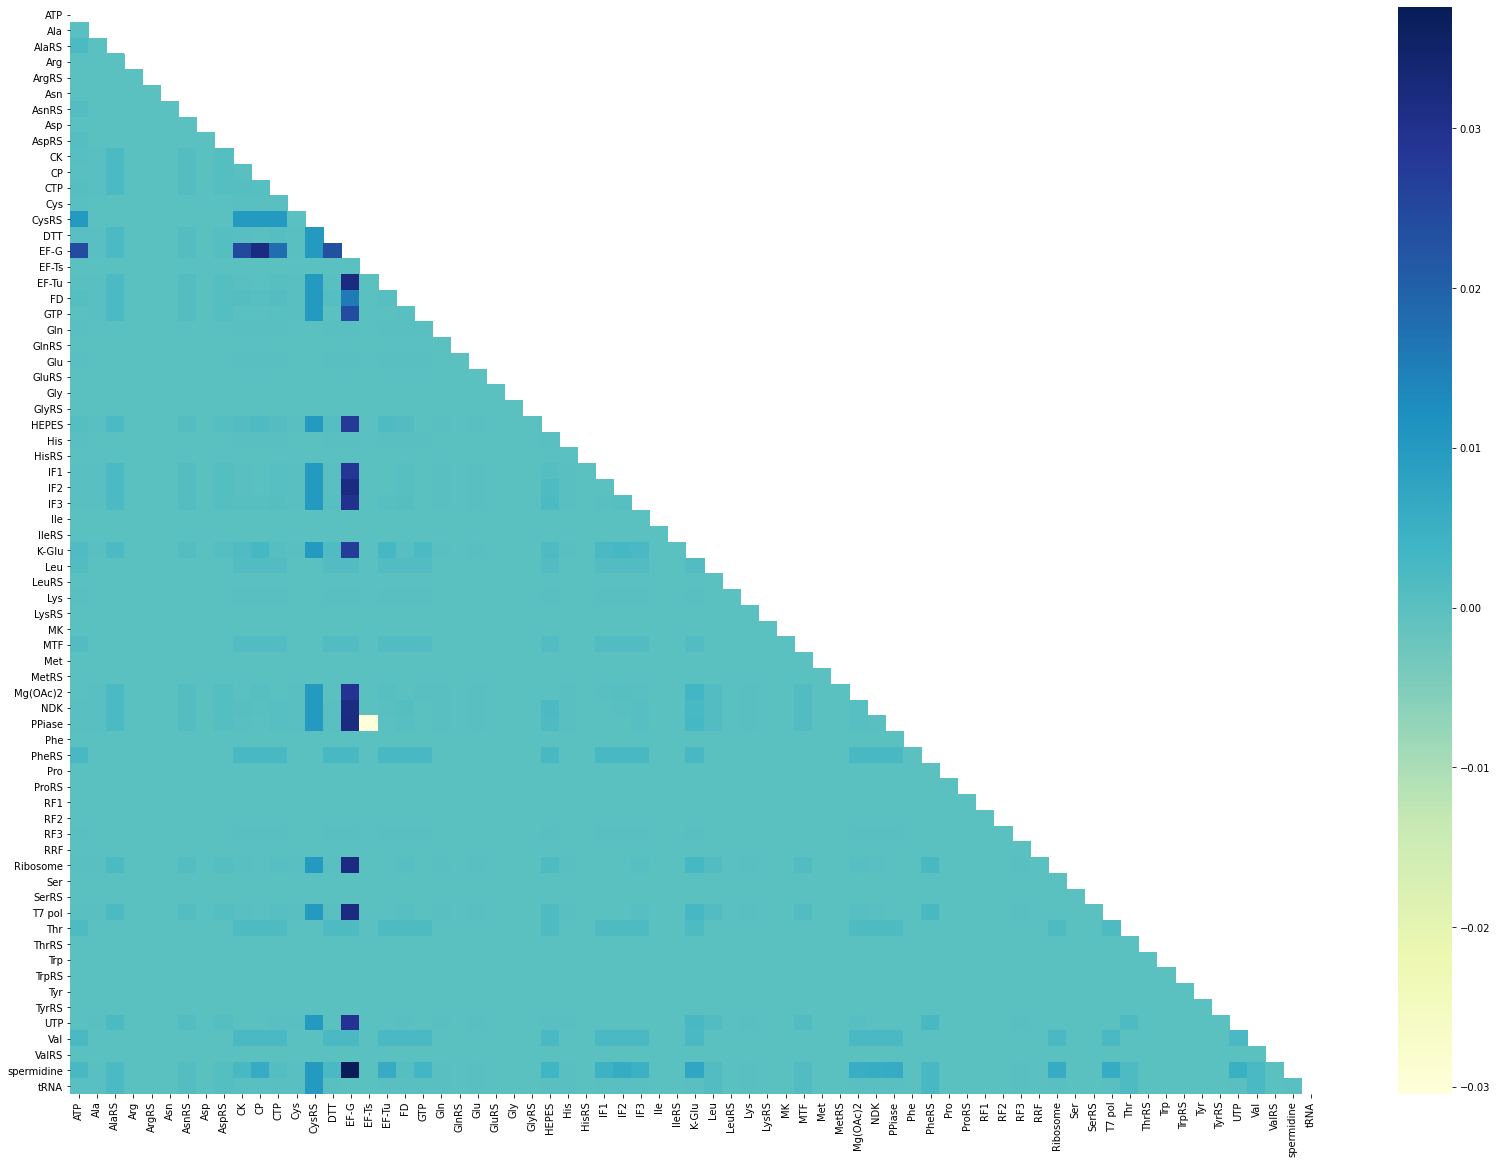

In [ ]:
corr = np.corrcoef(np.random.randn(len(aggregated_data_m.columns), 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (28, 20))
ax = sns.heatmap(interactions_df, mask=mask, cmap='YlGnBu')
# simulation of active learning approuch number 1 was used for this graph

In [ ]:
fig.savefig('Interactions.png', format='png', dpi=1200)
fig.savefig('Interactions.svg', format='svg', dpi=1200)